# Необходимо классифицировать семейства лягушек в зависимости от особенностей их кваканья и прочих звуковых эффектов.
Будем решать задачу бинарной классификации по выявлению лягушек, 

которые относятся к семейству 'Dendrobatidae' (признак 'Family'). 

Семейство 'Dendrobatidae' будет классом 1, все остальные семейства — классом 0.

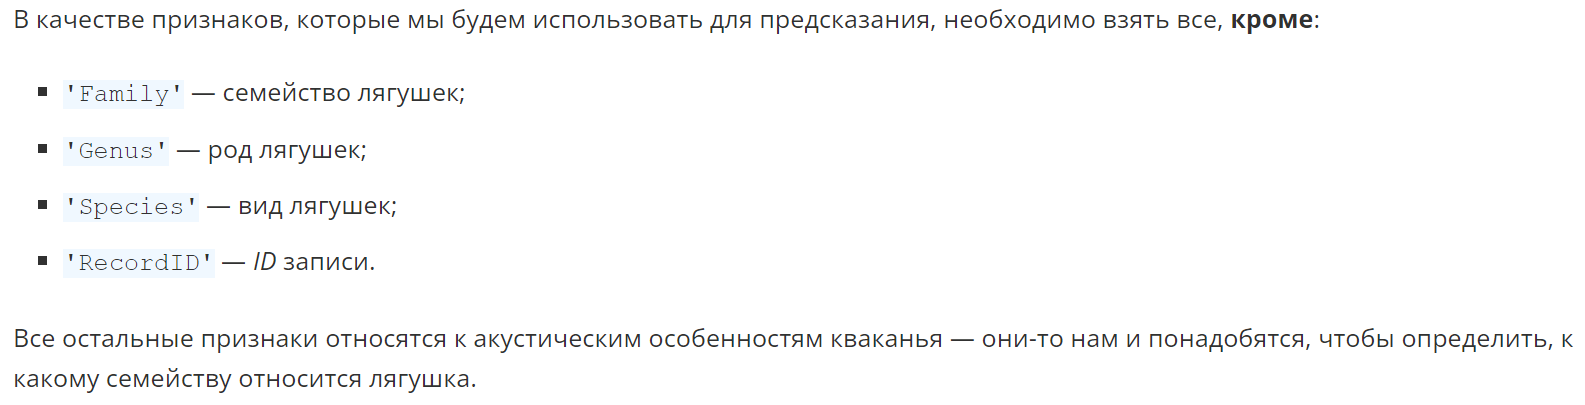

In [81]:
# для автозагрузки изменений в модулях без необходимости перезагрузки kelner
%load_ext autoreload
%autoreload 2

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# необходимо для корректного импорта своих модулей в JupyterLab
import sys
current_dir = sys.path[0]
project_dir = 'SF_DS_Pro'
last_position = current_dir.find(project_dir) + len(project_dir)
project_path = current_dir[:last_position]
sys.path.append(project_path)

import Handlers as hd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn import set_config
set_config(transform_output='pandas')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

sns.set_theme('notebook') 
sns.set_palette('Set2')

plt.rcParams['figure.figsize'] = (12, 8) 

In [83]:
df = pd.read_csv('data/Frogs_MFCCs.zip')
df.drop(columns=['Genus', 'Species', 'RecordID'], inplace=True)
TARGET = 'Family'

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7195 entries, 0 to 7194
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   MFCCs_ 1  7195 non-null   float64
 1   MFCCs_ 2  7195 non-null   float64
 2   MFCCs_ 3  7195 non-null   float64
 3   MFCCs_ 4  7195 non-null   float64
 4   MFCCs_ 5  7195 non-null   float64
 5   MFCCs_ 6  7195 non-null   float64
 6   MFCCs_ 7  7195 non-null   float64
 7   MFCCs_ 8  7195 non-null   float64
 8   MFCCs_ 9  7195 non-null   float64
 9   MFCCs_10  7195 non-null   float64
 10  MFCCs_11  7195 non-null   float64
 11  MFCCs_12  7195 non-null   float64
 12  MFCCs_13  7195 non-null   float64
 13  MFCCs_14  7195 non-null   float64
 14  MFCCs_15  7195 non-null   float64
 15  MFCCs_16  7195 non-null   float64
 16  MFCCs_17  7195 non-null   float64
 17  MFCCs_18  7195 non-null   float64
 18  MFCCs_19  7195 non-null   float64
 19  MFCCs_20  7195 non-null   float64
 20  MFCCs_21  7195 non-null   floa

In [85]:
# кодирую целевой признак
df[TARGET] = df[TARGET].apply(lambda x: 1 if x == 'Dendrobatidae' else 0)

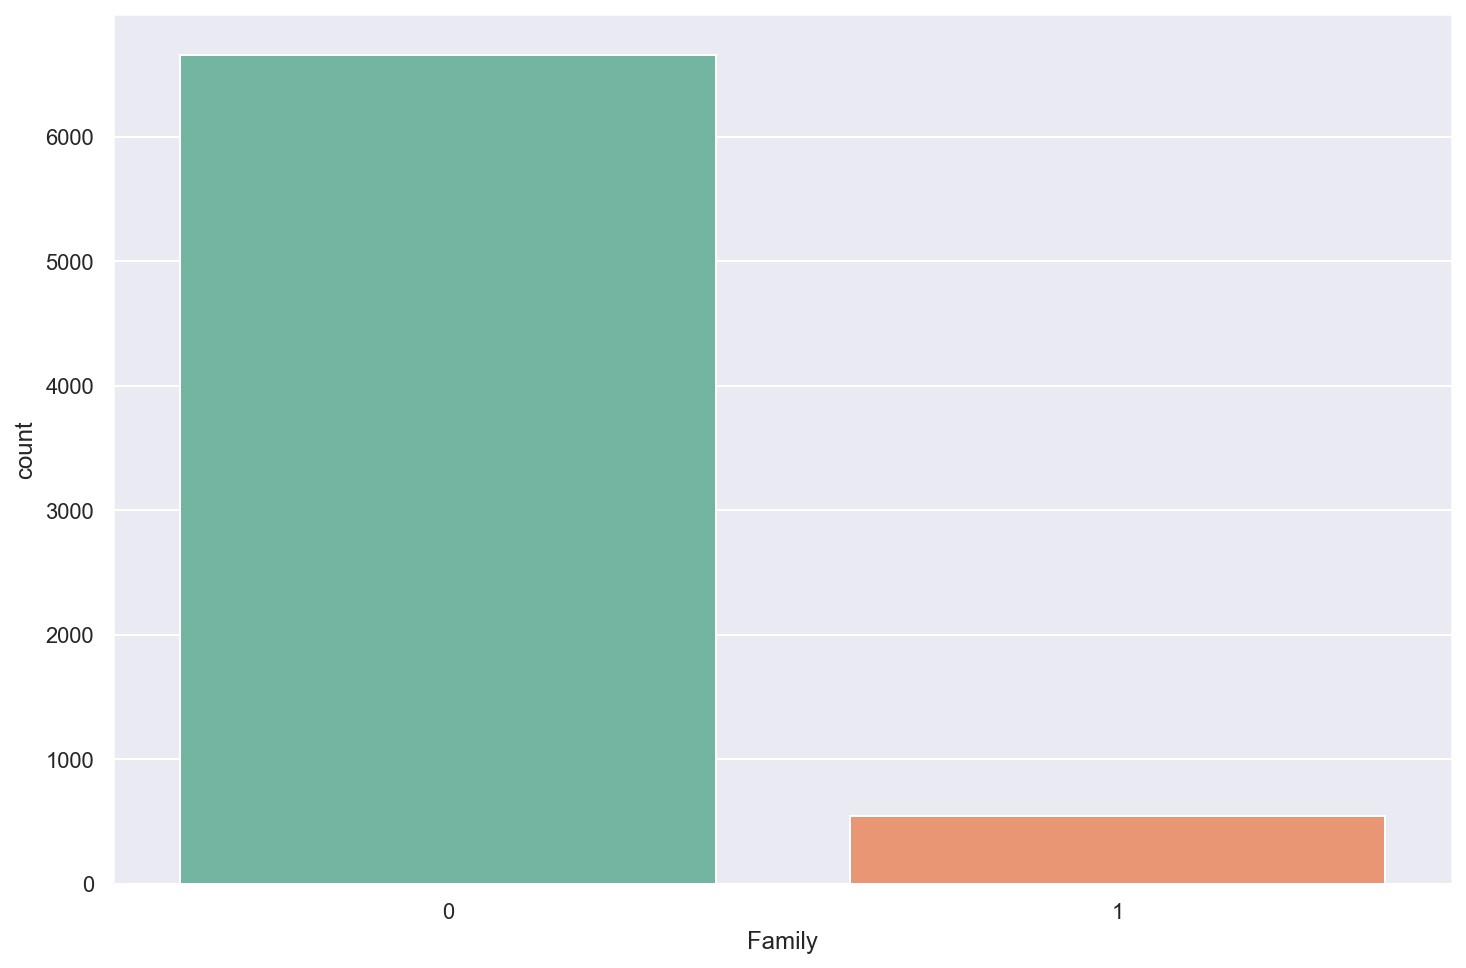

In [87]:
sns.countplot(data=df, x=TARGET);

Наблюдается максимальный дисбаланс класса

In [88]:
df[TARGET].value_counts(True) * 100

Family
0    92.466991
1     7.533009
Name: proportion, dtype: float64

Разделите выборку на обучающую и тестовую в соотношении 80/20, параметр random_state = 31.

In [89]:
X, y = df.drop(columns=TARGET), df[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=31)

In [90]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [71]:
model = RandomForestClassifier(n_estimators=10, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f'On train f1_score {f1_score(y_train, y_train_pred):.2f}')
print(f'On train precision {precision_score(y_train, y_train_pred):.2f}')
print()
print(f'On test f1_score {f1_score(y_test, y_test_pred):.2f}')
print(f'On test precision {precision_score(y_test, y_test_pred):.2f}')

On train f1_score 0.99
On train precision 1.00

On test f1_score 0.98
On test precision 1.00


In [72]:
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Define the base models
base_models = [
               ('rf', RandomForestClassifier(n_estimators=10, random_state=31)),
               ('knn', KNeighborsClassifier(n_neighbors=11)),
               ('gnb', GaussianNB())
              ]

# Initialize StackingClassifier with the Meta-Estimator
clf = StackingClassifier(
    estimators=base_models, final_estimator=LogisticRegression()
)

# Fit the model on the training data and predict on the test data
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

print(f'On train f1_score {f1_score(y_train, y_train_pred):.2f}')
print(f'On train precision {precision_score(y_train, y_train_pred):.2f}')
print()
print(f'On test f1_score {f1_score(y_test, y_test_pred):.2f}')
print(f'On test precision {precision_score(y_test, y_test_pred):.2f}')

On train f1_score 1.00
On train precision 1.00

On test f1_score 1.00
On test precision 1.00


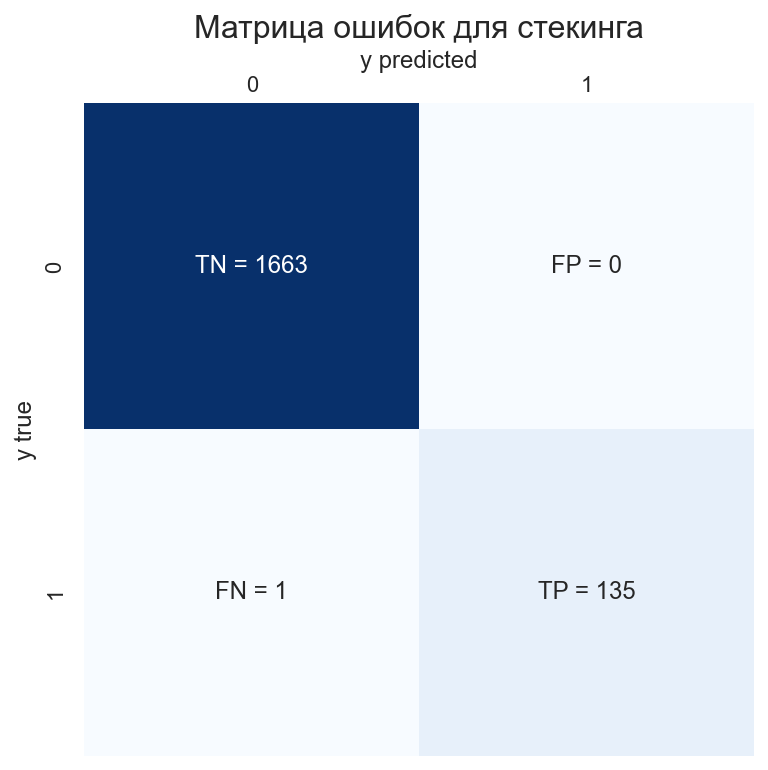

In [94]:
hd.plot_confusion_matrix(confusion_matrix(y_test, y_test_pred),
                         'Матрица ошибок для стекинга')